In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import random
from random import shuffle
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import classification_report
import time

import keras
from keras.applications import VGG16, DenseNet121, InceptionV3
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import TensorBoard,ModelCheckpoint, LearningRateScheduler
from keras.models import Sequential
from keras import backend as K
import tensorflow as tf
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D


import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d,avg_pool_2d, conv_3d, max_pool_3d, avg_pool_3d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.merge_ops import merge

## Concatenate to 1 NPY file

In [2]:
# Concatenate to 1 NPY
files = glob("object_detection/frames3/*")
shuffle(files)
file_list = []
for file in files:
    npy_file = np.load(file)
    shuffle(npy_file)
    file_list.append(npy_file)
full_data = np.concatenate(file_list)
np.save('full_data', full_data)

## Frequency Distribution Analysis

In [3]:
def get_frequency(np_array, title=None):
    np_copy = np.copy(np_array)
    df = pd.DataFrame(np_copy, columns=['frames', 'label'])
    df.label = df.label.astype(str)
    count_labels = df.label.value_counts() #normalize=True
    n_labels = count_labels.tolist()
    labels = count_labels.index.tolist()
    print(count_labels)
    plt.figure(figsize=(10,5))
    plt.bar(labels, n_labels)
    plt.title(title)

[1, 0, 0, 0, 0]    3114
[0, 0, 0, 0, 0]     262
[0, 0, 0, 0, 1]     260
[0, 0, 0, 1, 0]     254
[0, 1, 0, 0, 0]      75
[0, 0, 1, 0, 0]      35
Name: label, dtype: int64


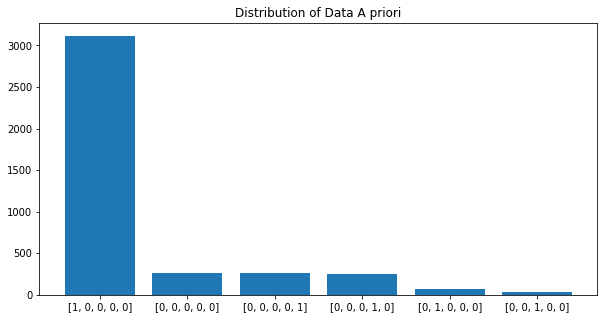

In [4]:
HEIGHT = 60
WIDTH = 107
CHANNEL = 1
data_analysis = np.load('full_data.npy')
get_frequency(data_analysis, 'Distribution of Data A priori')

### Dividing Forward

In [7]:
# Divide FWD by 2 
def dividing_data(initial_list, dividing_factor=1):
    full_data_copy = np.copy(initial_list)
    df_copy = pd.DataFrame(full_data_copy, columns=['frames', 'label'])
    df_copy.label = df_copy.label.astype(str)

    fwd_indexes = np.where(full_data_copy[:,1]=="[1, 0, 0, 0, 0]")[0]
    n_fwd = fwd_indexes.shape[0]
    rdm_fwd = np.random.choice(a=fwd_indexes, size=int(n_fwd*dividing_factor), replace=False)

    processed_list = np.delete(initial_list, rdm_fwd, axis=0)
    return processed_list

data_processed= dividing_data(data_analysis, 0.7)
# print(np.asarray(data_processed).shape)
data_processed.shape

(1821, 2)

### Delete Verification

[1, 0, 0, 0, 0]    935
[0, 0, 0, 0, 0]    262
[0, 0, 0, 0, 1]    260
[0, 0, 0, 1, 0]    254
[0, 1, 0, 0, 0]     75
[0, 0, 1, 0, 0]     35
Name: label, dtype: int64


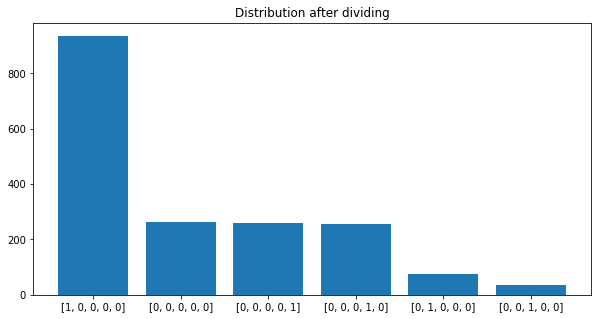

In [8]:
get_frequency(data_processed, 'Distribution after dividing')

## Train/ Validation/ Test Split

[1, 0, 0, 0, 0]    748
[0, 0, 0, 0, 0]    209
[0, 0, 0, 0, 1]    208
[0, 0, 0, 1, 0]    203
[0, 1, 0, 0, 0]     60
[0, 0, 1, 0, 0]     28
Name: label, dtype: int64
[1, 0, 0, 0, 0]    93
[0, 0, 0, 0, 0]    26
[0, 0, 0, 0, 1]    26
[0, 0, 0, 1, 0]    25
[0, 1, 0, 0, 0]     8
[0, 0, 1, 0, 0]     4
Name: label, dtype: int64
[1, 0, 0, 0, 0]    94
[0, 0, 0, 0, 0]    27
[0, 0, 0, 0, 1]    26
[0, 0, 0, 1, 0]    26
[0, 1, 0, 0, 0]     7
[0, 0, 1, 0, 0]     3
Name: label, dtype: int64


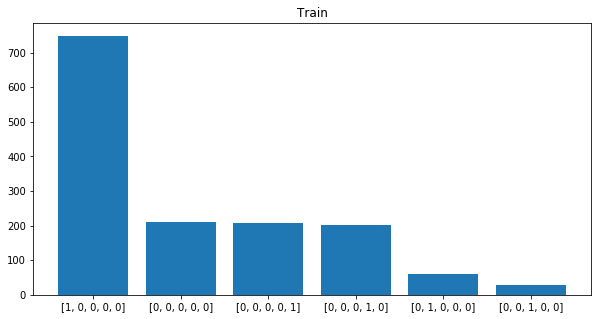

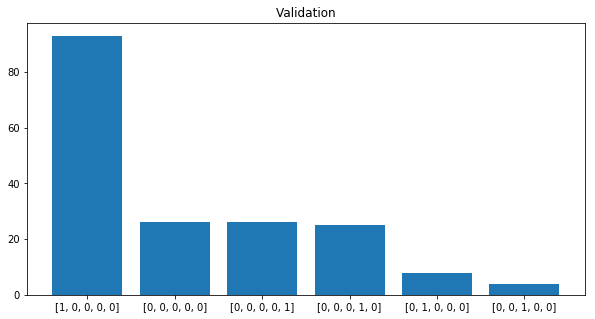

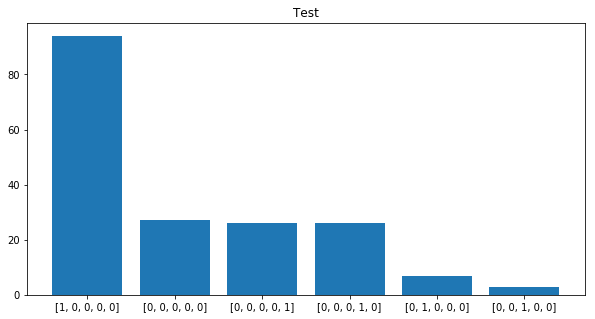

In [9]:
# Train/ Val / Test
X = data_processed[:,0]
y = data_processed[:,1]

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, stratify=y_val_test)

train = np.concatenate([X_train.reshape(-1,1), y_train.reshape(-1,1)], axis=1)
validation = np.concatenate([X_val.reshape(-1,1), y_val.reshape(-1,1)], axis=1)
test = np.concatenate([X_test.reshape(-1,1), y_test.reshape(-1,1)], axis=1)

get_frequency(train, 'Train')
get_frequency(validation, 'Validation')
get_frequency(test, 'Test')

### Reshape for Fitting

In [10]:
X_train = np.array([element for element in X_train]).reshape(-1, HEIGHT, WIDTH,  1)
X_val = np.array([element for element in X_val]).reshape(-1, HEIGHT, WIDTH, 1)
X_test = np.array([element for element in X_test]).reshape(-1, HEIGHT, WIDTH, 1)


X_train_rgb = np.repeat(X_train[np.newaxis], 3, -1)[0]
X_val_rgb = np.repeat(X_val[np.newaxis], 3, -1)[0]
X_test_rgb = np.repeat(X_test[np.newaxis], 3, -1)[0]

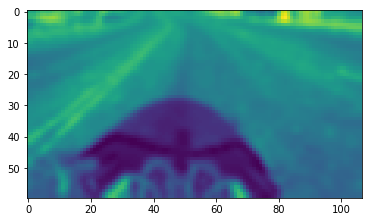

In [11]:
plt.imshow(X_train[150].reshape(HEIGHT, WIDTH))

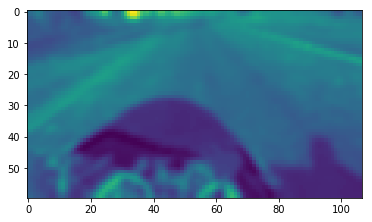

In [113]:
plt.imshow(X_train[30].reshape(HEIGHT, WIDTH))

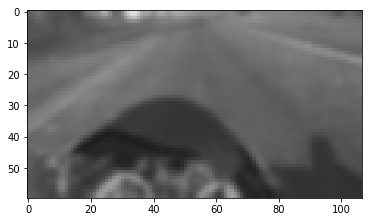

In [112]:
plt.imshow(X_train_rgb[30])

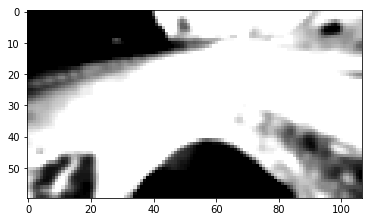

In [110]:
img = X_train_rgb[0]
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def pan(image):
#     image = image.reshape(HEIGHT, WIDTH)
    aug = iaa.ContrastNormalization((5, 8))
    image = aug.augment_image(image)
    plt.imshow(image)
pan(img) 

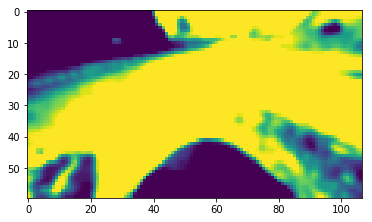

In [111]:
img = X_train[0]
pan(img.reshape(HEIGHT, WIDTH))

# Data Augmentation 1D

In [27]:
def contrast_norm(image):
    image = image.reshape(HEIGHT, WIDTH)
    random_constrat = round(np.random.uniform(5,8),2)
    contrast = iaa.ContrastNormalization((random_constrat, random_constrat))
    image = contrast.augment_image(image)
    return np.expand_dims(image, -1)

def erosion_image(image):
    image = image.reshape(HEIGHT, WIDTH)
    shift = np.random.randint(5)
    kernel = np.ones((shift,shift),np.uint8)
    image = cv2.erode(image,kernel,iterations = 1)
    return np.expand_dims(image, -1)

def flip_img(image, label):
    image = image.reshape(HEIGHT, WIDTH)
    RIGHT = "[0, 0, 1, 0, 0]"
    LEFT = "[0, 1, 0, 0, 0]"
    FWD_RIGHT = "[0, 0, 0, 0, 1]"
    FWD_LEFT = "[0, 0, 0, 1, 0]"
    
    if label == RIGHT:
        label_aug = LEFT
    elif label == LEFT:
        label_aug = RIGHT
    elif label == FWD_RIGHT:
        label_aug = FWD_LEFT
    elif label == FWD_LEFT:
        label_aug = FWD_RIGHT
    else:
        label_aug = label
    return np.expand_dims(np.fliplr(image), -1), label_aug 

def zoom(image):
    image = image.reshape(HEIGHT, WIDTH)
    random_scale = round(np.random.uniform(1,1.5),2)
    zoom = iaa.Affine(scale=(random_scale, random_scale))
    image = zoom.augment_image(image)
    return np.expand_dims(image, -1)

def pan(image):
    image = image.reshape(HEIGHT, WIDTH)
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return np.expand_dims(image, -1)

def gaussian_noise(image):
    image = image.reshape(HEIGHT, WIDTH)
    noise = iaa.AdditiveGaussianNoise(scale=0.05*255)
    image = noise.augment_image(image)
    return np.expand_dims(image, -1)

def edge_detector(image):
    image = image.reshape(HEIGHT, WIDTH)
    random_edges = round(np.random.uniform(0,1),2)
    edge = iaa.EdgeDetect(alpha=(random_edges, random_edges))
    image = edge.augment_image(image)
    return np.expand_dims(image, -1)

In [28]:
def random_augmentation(frame, label):
    
    frame = frame/255.0
    batch_frame_aug, batch_label_aug = [], []
    batch_frame_aug.append(frame)
    batch_label_aug.append(label)
#     print(frame.shape)
    if np.random.rand() <= 0.5:
#         print('CONTRAST')
        frame_constrast = contrast_norm(frame)
        batch_frame_aug.append(frame_constrast)
        batch_label_aug.append(label)
    if np.random.rand() <= 0.5:
#         print("ERO")
        frame_ero = erosion_image(frame)
        batch_frame_aug.append(frame_ero)
        batch_label_aug.append(label)
    if np.random.rand() <= 0.5:
#         print("FLIP")
        frame_flip, label_flip = flip_img(frame, label)
        batch_frame_aug.append(frame_flip)
        batch_label_aug.append(label_flip)
    if np.random.rand() <= 0.5:
#         print('ZOOM')
        frame_zoom = zoom(frame)
        batch_frame_aug.append(frame_zoom)
        batch_label_aug.append(label)
    if np.random.rand() <= 0.5:
#         print("PAN")
        frame_pan = pan(frame)
        batch_frame_aug.append(frame_pan)
        batch_label_aug.append(label)
    if np.random.rand() <= 0.5:
#         print("NOISE")
        frame_noise = gaussian_noise(frame)
        batch_frame_aug.append(frame_noise)
        batch_label_aug.append(label)
    if np.random.rand() <= 0.5:
#         print("EDGE")
        frame_edge = edge_detector(frame)
        batch_frame_aug.append(frame_edge)
        batch_label_aug.append(label)

    return batch_frame_aug, batch_label_aug

# Create Generator

In [29]:
def my_generator(frames, labels, batch_size, data_augmented):

        FWD = "[1, 0, 0, 0, 0]"
        while True:
            batch_frames = []
            batch_labels = []

            random_index = np.random.choice(a = frames.shape[0], size=batch_size)

            for idx in random_index:
#                 frames[idx] = np.resize(frames[idx], (66,200) )
                if data_augmented and str(labels[idx]) != FWD:
#                     print('AUGMENTED')
                    frame, label = random_augmentation(frames[idx], labels[idx])

                    batch_frames += frame
                    batch_labels += label

                else:
#                     print("ELSE")
                    frame, label = frames[idx]/255.0, labels[idx]
                    
                    batch_frames += [frame]
                    batch_labels += [label]

            yield (np.asarray(batch_frames), np.asarray(batch_labels))

In [30]:
x_train_gen, y_train_gen = next(my_generator(X_train, y_train, 3, True))
x_valid_gen, y_valid_gen = next(my_generator(X_val, y_val, 1, False))
x_test_gen, y_test_gen = next(my_generator(X_test, y_test, 1, False))
print(x_train_gen.shape)
print(y_train_gen)

(5, 60, 107, 1)
[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


# Fit Generator

In [104]:
# # Define our custom loss function
# def focal_loss(y_true, y_pred):
#     print(y_true)
#     print(y_pred)
#     gamma = 2
#     alpha = 0.25
#     pt_1 = tf.where(tf.equal(y_true, [1,0,0,0,0]), y_pred, tf.ones_like(y_pred))
#     pt_0 = tf.where(tf.equal(y_true, [0,0,0,0,0]), y_pred, tf.zeros_like(y_pred))
#     print(pt_0)
#     print(pt_1)
#     return -K.sum(0.5*K.pow(2, gamma))
# #     return -K.sum(alpha * K.pow(1 - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1 - pt_0))

# y_true = [1,0,0,0,0]
# y_pred = [0,0,0,0,0]

# focal_loss(y_true, y_pred)
# # # Compile our model
# # adam = Adam(lr=0.0001)
# # model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=adam)

## Hand Model

In [58]:
model = Sequential()
model.add( Conv2D(64, (3, 3), input_shape = (HEIGHT, WIDTH, CHANNEL)) )
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 58, 105, 64)       640       
_________________________________________________________________
activation_46 (Activation)   (None, 58, 105, 64)       0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 29, 52, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 27, 50, 64)        36928     
_________________________________________________________________
activation_47 (Activation)   (None, 27, 50, 64)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 25, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 20800)             0         
__________

In [59]:
BATCH_SIZE = 16
N_TRAIN = X_train.shape[0]
N_VAL = X_val.shape[0]
N_TEST = X_test.shape[0]

In [156]:
checkpointer = ModelCheckpoint(filepath='drving_gta_hand.hdf5', verbose=1, save_best_only=True)

# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
NAME = 'drving_gta_hand_60x107_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

def lr_schedule(epoch):
    """Change the learning rate """
    lrate = 0.001
    if epoch > 10:
        lrate = 0.0005
    if epoch > 50:
        lrate = 0.0003
    return lrate

# tensorboard --logdir=logs/ --host localhost --port 8088

History = model.fit_generator(my_generator(X_train, y_train, BATCH_SIZE, True),
                                  steps_per_epoch=N_TRAIN // BATCH_SIZE, 
                                  epochs=2,
                                  validation_data=my_generator(X_val, y_val, BATCH_SIZE, False),
                                  validation_steps=N_VAL // BATCH_SIZE,
                                  verbose=1,
                                  callbacks=[tensorboard, LearningRateScheduler(lr_schedule), checkpointer],
                                  shuffle = 1)

# # Saving
# model.save('drving_gta_hand.h5')

Epoch 1/2
89/89 [==============================] - ETA: 2:29 - loss: 1.7183 - acc: 0.205 - ETA: 1:43 - loss: 1.7568 - acc: 0.177 - ETA: 1:28 - loss: 1.6532 - acc: 0.232 - ETA: 1:23 - loss: 1.5568 - acc: 0.216 - ETA: 1:19 - loss: 1.5132 - acc: 0.205 - ETA: 1:14 - loss: 1.4055 - acc: 0.185 - ETA: 1:10 - loss: 1.4115 - acc: 0.179 - ETA: 1:11 - loss: 1.4245 - acc: 0.189 - ETA: 1:10 - loss: 1.4626 - acc: 0.191 - ETA: 1:08 - loss: 1.4380 - acc: 0.192 - ETA: 1:07 - loss: 1.4372 - acc: 0.193 - ETA: 1:05 - loss: 1.4092 - acc: 0.186 - ETA: 1:04 - loss: 1.3827 - acc: 0.195 - ETA: 1:03 - loss: 1.4039 - acc: 0.202 - ETA: 1:02 - loss: 1.4108 - acc: 0.207 - ETA: 1:01 - loss: 1.4102 - acc: 0.211 - ETA: 1:01 - loss: 1.4116 - acc: 0.219 - ETA: 1:00 - loss: 1.4305 - acc: 0.218 - ETA: 1:00 - loss: 1.4240 - acc: 0.219 - ETA: 58s - loss: 1.4304 - acc: 0.216 - ETA: 57s - loss: 1.4132 - acc: 0.22 - ETA: 55s - loss: 1.4232 - acc: 0.21 - ETA: 54s - loss: 1.4397 - acc: 0.21 - ETA: 53s - loss: 1.4480 - acc: 0.21 

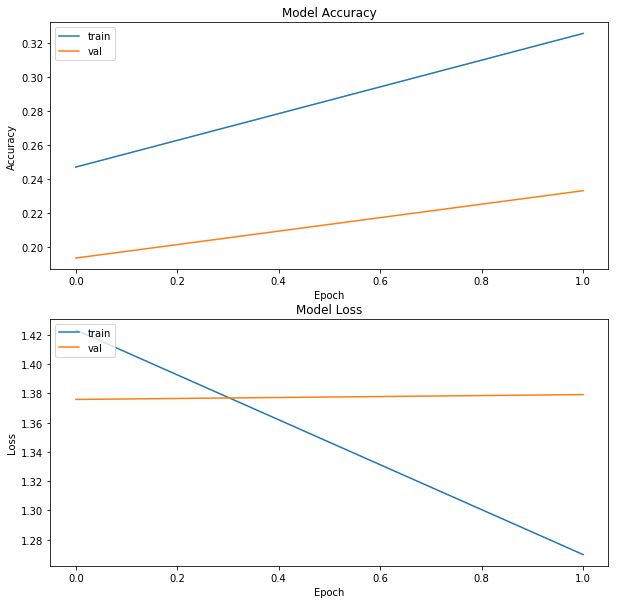

In [157]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(History.history['acc'])  
plt.plot(History.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [60]:
model.load_weights('drving_gta_hand.hdf5')
(eval_loss, eval_accuracy) = model.evaluate_generator(my_generator(X_test, y_test, BATCH_SIZE, False),steps = N_TEST//BATCH_SIZE , verbose=1)

11/11 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 223ms/step


In [61]:
print("Test Accuracy: {}%".format(eval_accuracy))

Test Accuracy: 0.14204545454545456%


In [62]:
predictions = model.predict_generator(my_generator(X_test, y_test, BATCH_SIZE, False),steps = N_TEST // BATCH_SIZE , verbose=1)
predictions

11/11 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 232ms/step


array([[0.2203495 , 0.21087384, 0.14132817, 0.20451277, 0.22293565],
       [0.22052108, 0.20990853, 0.14055134, 0.20613387, 0.22288515],
       [0.21816862, 0.21185741, 0.14254223, 0.20567538, 0.22175632],
       [0.2161248 , 0.21049646, 0.14379254, 0.20342599, 0.22616024],
       [0.22490083, 0.2076892 , 0.137945  , 0.20266594, 0.22679897],
       [0.21962161, 0.21118563, 0.14098345, 0.20580989, 0.22239934],
       [0.21804945, 0.21118304, 0.14184573, 0.20516035, 0.2237614 ],
       [0.2234252 , 0.20854732, 0.13911828, 0.20348862, 0.22542061],
       [0.22446269, 0.20789905, 0.1379264 , 0.20273836, 0.22697349],
       [0.2265938 , 0.20618571, 0.13671663, 0.20161518, 0.22888865],
       [0.2104996 , 0.21591143, 0.14784154, 0.21018475, 0.21556276],
       [0.2161248 , 0.21049646, 0.14379254, 0.20342599, 0.22616024],
       [0.21963678, 0.21021836, 0.14117494, 0.20454487, 0.22442497],
       [0.2161248 , 0.21049646, 0.14379254, 0.20342599, 0.22616024],
       [0.21962161, 0.21118563, 0.

In [108]:
# y_w = np.ones(5)
# validation_keys = y_val[0]
# y_proba = model.predict(np.expand_dims(X_val[0],0))
# y_pred = np.argmax(y_proba)
# y_real = np.argmax(validation_keys)
# y_loss = (y_proba - validation_keys)**2
# print("Real   ",validation_keys)
# print("Predict", y_proba)
# print("Loss   ", y_loss)
# print("W", (y_w - y_loss))

Real    [0, 0, 0, 0, 1]
Predict [[1.2753608e-12 5.0354279e-17 9.9994528e-01 4.3680910e-05 1.1111497e-05]]
Loss    [[1.62654513e-24 2.53555341e-33 9.99890569e-01 1.90802186e-09
  9.99977777e-01]]
W [[1.00000000e+00 1.00000000e+00 1.09431134e-04 9.99999998e-01
  2.22228703e-05]]


In [181]:
y_pred = np.argmax(predictions, axis=1)
y_true = [np.argmax(label_test) for label_test in y_test]

In [ ]:
# prediction = model.predict([screen.reshape(WIDTH,HEIGHT,3)])[0]
# prediction = np.array(prediction) * np.array([4.5, 0.1, 0.1, 0.1,  1.8,   1.8, 0.5, 0.5, 0.2])

## NVIDIA

In [200]:
model = Sequential()
model.add(Conv2D(24, 5, 5, input_shape=(HEIGHT, WIDTH, CHANNEL), activation='elu'))
model.add(Conv2D(36, 5, 5, activation='elu'))
model.add(Conv2D(48, 5, 5, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100, activation = 'elu'))
model.add(Dense(50, activation = 'elu'))
model.add(Dense(10, activation = 'elu'))
model.add(Dense(5))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

model.summary()

C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(60, 107, ..., activation="elu")`
  
C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu")`
  after removing the cwd from sys.path.
C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  """
C:\Users\micka\Anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 56, 103, 24)       624       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 52, 99, 36)        21636     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 48, 95, 48)        43248     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 46, 93, 64)        27712     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 44, 91, 64)        36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 44, 91, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256256)            0         
__________

In [185]:
checkpointer = ModelCheckpoint(filepath='drving_gta_nvidia.hdf5', verbose=1, save_best_only=True)

# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
NAME = 'drving_gta_nvidia_60x107_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

def lr_schedule(epoch):
    """Change the learning rate """
    lrate = 0.001
    if epoch > 10:
        lrate = 0.0005
    if epoch > 50:
        lrate = 0.0003
    return lrate

# tensorboard --logdir=logs/ --host localhost --port 8088

History = model.fit_generator(my_generator(X_train, y_train, BATCH_SIZE, True),
                                  steps_per_epoch=N_TRAIN // BATCH_SIZE, 
                                  epochs=2,
                                  validation_data=my_generator(X_val, y_val, BATCH_SIZE, False),
                                  validation_steps=N_TEST // BATCH_SIZE,
                                  verbose=1,
                                  callbacks=[tensorboard, LearningRateScheduler(lr_schedule), checkpointer],
                                  shuffle = 1)

# # Saving
# model.save('drving_gta_hand.h5')

Epoch 1/2
21/89 [======>.......................] - ETA: 19:44 - loss: 0.9984 - acc: 0.11 - ETA: 17:38 - loss: 1.1327 - acc: 0.18 - ETA: 16:15 - loss: 1.1970 - acc: 0.23 - ETA: 13:54 - loss: 1.3825 - acc: 0.20 - ETA: 13:35 - loss: 1.4089 - acc: 0.23 - ETA: 13:24 - loss: 1.3745 - acc: 0.25 - ETA: 13:43 - loss: 1.3870 - acc: 0.27 - ETA: 13:35 - loss: 1.3709 - acc: 0.26 - ETA: 14:07 - loss: 1.3337 - acc: 0.28 - ETA: 14:18 - loss: 1.2765 - acc: 0.30 - ETA: 13:57 - loss: 1.2899 - acc: 0.30 - ETA: 13:46 - loss: 1.3090 - acc: 0.30 - ETA: 13:24 - loss: 1.2741 - acc: 0.32 - ETA: 13:04 - loss: 1.2642 - acc: 0.32 - ETA: 12:47 - loss: 1.2729 - acc: 0.32 - ETA: 12:45 - loss: 1.2462 - acc: 0.33 - ETA: 12:27 - loss: 1.2476 - acc: 0.33 - ETA: 12:09 - loss: 1.2361 - acc: 0.34 - ETA: 11:56 - loss: 1.2193 - acc: 0.35 - ETA: 11:36 - loss: 1.2102 - acc: 0.35 - ETA: 11:17 - loss: 1.2258 - acc: 0.3558

KeyboardInterrupt: 

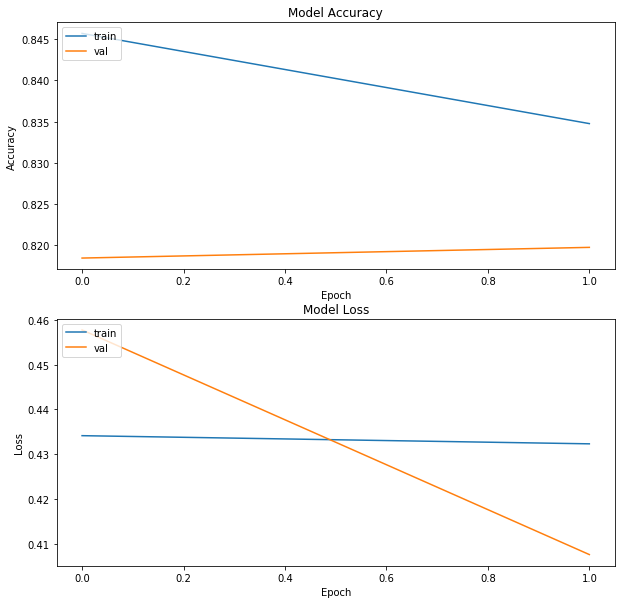

In [802]:
plt.figure(1, figsize=(10,10))  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(History.history['acc'])  
plt.plot(History.history['val_acc'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [803]:
model.load_weights('drving_gta_nvidia.hdf5')
(eval_loss, eval_accuracy) = model.evaluate_generator(my_generator(X_test, y_test, BATCH_SIZE, False),steps = N_TEST // BATCH_SIZE, verbose=1)

50/50 [==============================] - ETA: 35 - ETA: 35 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 34 - ETA: 33 - ETA: 32 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 36s 725ms/step


In [804]:
print("Test Accuracy: {}%".format(eval_accuracy))

Test Accuracy: 0.8208000254631043%


In [ ]:
predictions = model.predict_generator(my_generator(X_test, y_test, BATCH_SIZE, False),steps = N_TEST // BATCH_SIZE, verbose=1)
predictions

## InceptionV3
Min 75x75

In [48]:
model_cnn = InceptionV3(weights=None, include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL))
model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape = model_cnn.output_shape[1:], data_format=None))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(5, activation='softmax'))

model = Model(inputs=model_cnn.input, outputs=model_top(model_cnn.output))
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

ValueError: Input size must be at least 75x75; got `input_shape=(60, 107, 1)`

## DenseNet
Must 3 Channels

In [49]:
cnn_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL))
full_model = cnn_model.output
full_model = Dropout(0.5)(full_model)
full_model = GlobalAveragePooling2D()(full_model)
full_model = Dense(256, activation='relu')(full_model)
full_model = BatchNormalization()(full_model)
predictions = Dense(n_classes, activation='sigmoid')(full_model)

model = Model(inputs=cnn_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

ValueError: The input must have 3 channels; got `input_shape=(60, 107, 1)`

## AlexNet

In [54]:
# Initialize model
alexnet = Sequential()

# Layer 1
alexnet.add(Conv2D(96, (11, 11), input_shape=(HEIGHT, WIDTH, CHANNEL), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
alexnet.add(Conv2D(256, (5, 5), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(512, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

# Layer 5
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(3072))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(4096))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(Dropout(0.5))

# Layer 8
alexnet.add(Dense(5))
alexnet.add(BatchNormalization())
alexnet.add(Activation('softmax'))

alexnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(alexnet.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 60, 107, 96)       11712     
_________________________________________________________________
batch_normalization_34 (Batc (None, 60, 107, 96)       384       
_________________________________________________________________
activation_38 (Activation)   (None, 60, 107, 96)       0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 53, 96)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 30, 53, 256)       614656    
_________________________________________________________________
batch_normalization_35 (Batc (None, 30, 53, 256)       1024      
_________________________________________________________________
activation_39 (Activation)   (None, 30, 53, 256)       0         
__________

In [56]:
checkpointer = ModelCheckpoint(filepath='drving_gta_alexnet.hdf5', verbose=1, save_best_only=True)

# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
NAME = 'drving_gta_alexnet_60x107_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

def lr_schedule(epoch):
    """Change the learning rate """
    lrate = 0.001
    if epoch > 10:
        lrate = 0.0005
    if epoch > 50:
        lrate = 0.0003
    return lrate

# tensorboard --logdir=logs/ --host localhost --port 8088

History = alexnet.fit_generator(my_generator(X_train, y_train, BATCH_SIZE, True),
                                  steps_per_epoch=N_TRAIN // BATCH_SIZE, 
                                  epochs=2,
                                  validation_data=my_generator(X_val, y_val, BATCH_SIZE, False),
                                  validation_steps=N_TEST // BATCH_SIZE,
                                  verbose=1,
                                  callbacks=[tensorboard, LearningRateScheduler(lr_schedule), checkpointer],
                                  shuffle = 1)

# # Saving
# model.save('drving_gta_hand.h5')

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'dict' object has no attribute 'name'
Epoch 1/2
 1/91 [..............................] - ETA: 1:35:02 - loss: 1.4260 - acc: 0.3333

KeyboardInterrupt: 